In [1]:
import numpy as np
import pandas as pd 
import os
from load_testdata import read_poly_coefficients, read_profile_pepsi, load_xyz, read_sasbdb
from debyecalc_Iq import DebyeCalculator
from collections import defaultdict
#from ../source_code/load_testdata import read_poly_coefficients, read_profile_pepsi, load_xyz, read_sasbdb

In [2]:
poly_coeffs = read_poly_coefficients('../poly_at.csv')

In [3]:
poly_coeffs
poly = poly_coeffs[poly_coeffs[:,0]=='H2O',2]
print(poly)

[9.998096755786294 0.0 -0.7939861642881193 -0.4523851090473768
 0.5582058579362125 -0.2293883781481107 0.0364585916559163]


In [4]:
files = os.listdir('../../experimental_data/')
for file in files:
    if file.endswith('.fit'):
        sasbdb_q, sasbdb_I, sasbdb_Imean = read_sasbdb(f'../../experimental_data/{file}')

In [5]:
import glob 
out_files = glob.glob('../pepsi-saxs_data/*.out')
log_files = glob.glob('../pepsi-saxs_data/*.log')

for out_file, log_file in zip(out_files, log_files):
    Iq_tot, Iat, Iev, Ihs, atev, aths, evhs, q_pepsi = read_profile_pepsi(out_file, log_file)

Scaling: 5.59512e-09
Scaling: 6.28696e-10
Scaling: 2.67226e-10
Scaling: 2.71495e-09
Scaling: 3.34523e-09


In [6]:
xyz_files = glob.glob('../cg_structures/*.xyz')

for i, xyz_file in enumerate(xyz_files):
    amino_acids, coordinates = load_xyz(xyz_file)
  

In [7]:
debye = DebyeCalculator(q_min=0.0, q_max=0.5, num_q_points=101)

#qvals, Iqvals = debye.calculate_Iq(xyz_files[0], poly_coeffs, solvent_coords)

In [10]:
def generate_hydration_shell(positions, cell_size=3.0, padding=12.0, min_dist=3.0, shell_width=3.0):
        """
        Generate a grid approximation of the hydration shell using the linked-cell approach.

        Parameters
        ----------
        positions : np.ndarray, shape (N,3)
            Atom positions.
        cell_size : float
            Grid spacing (Å).
        padding : float
            Extra padding beyond molecule bounding box (Å).
        min_dist : float
            Minimum distance from any atom (Å).
        shell_width : float
            Width of hydration shell (Å).

        Returns
        -------
        shell_cells : np.ndarray, shape (M,3)
            Centers of the cells approximating the hydration shell.
        """
        # 1. Bounding box with padding
        min_corner = np.min(positions, axis=0) - padding
        max_corner = np.max(positions, axis=0) + padding

        # 2. Create 3D grid of cell centers
        x = np.arange(np.floor(min_corner[0]), np.ceil(max_corner[0]) + cell_size, cell_size)
        y = np.arange(np.floor(min_corner[1]), np.ceil(max_corner[1]) + cell_size, cell_size)
        z = np.arange(np.floor(min_corner[2]), np.ceil(max_corner[2]) + cell_size, cell_size)
        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
        cell_centers = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

        # 3. Assign atoms to cells
        cell_indices = np.floor((positions - min_corner) / cell_size).astype(int)
        cells = defaultdict(list)
        for idx, (i, j, k) in enumerate(cell_indices):
            cells[(i, j, k)].append(idx)

        n_cells = (np.ceil((max_corner - min_corner) / cell_size)).astype(int)

        # Helper: get 26 neighbors + self
        def neighbor_cells(i, j, k):
            neighbors = []
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    for dk in [-1, 0, 1]:
                        ni, nj, nk = i + di, j + dj, k + dk
                        # ignore out-of-bounds
                        if 0 <= ni < n_cells[0] and 0 <= nj < n_cells[1] and 0 <= nk < n_cells[2]:
                            neighbors.append((ni, nj, nk))
            return neighbors

        # 4. Filter cells
        shell_cells = []
        for idx, center in enumerate(cell_centers):
            i = int(np.floor((center[0] - min_corner[0]) / cell_size))
            j = int(np.floor((center[1] - min_corner[1]) / cell_size))
            k = int(np.floor((center[2] - min_corner[2]) / cell_size))

            # Collect atoms in this cell + neighbors
            neighbor_atoms = []
            for ci, cj, ck in neighbor_cells(i, j, k):
                neighbor_atoms.extend(cells.get((ci, cj, ck), []))
            if not neighbor_atoms:
                continue  # skip empty regions

            # Compute distances
            dists = np.linalg.norm(positions[neighbor_atoms] - center, axis=1)
            # Apply criteria
            if np.all(dists > min_dist) and np.any(dists < (min_dist + shell_width)):
                shell_cells.append(center)

        return np.array(shell_cells)

In [17]:
water_pos =generate_hydration_shell(coordinates, cell_size=5.0, padding=12.0, min_dist=5.0, shell_width=5.0)

In [18]:
qvals, Iqvals = debye.calculate_Iq(xyz_files[0], poly_coeffs, water_pos)


['LYS' 'VAL' 'PHE' 'GLY' 'ARG' 'CYS' 'GLU' 'LEU' 'ALA' 'ALA' 'ALA' 'MET'
 'LYS' 'ARG' 'HIS' 'GLY' 'LEU' 'ASP' 'ASN' 'TYR' 'ARG' 'GLY' 'TYR' 'SER'
 'LEU' 'GLY' 'ASN' 'TRP' 'VAL' 'CYS' 'ALA' 'ALA' 'LYS' 'PHE' 'GLU' 'SER'
 'ASN' 'PHE' 'ASN' 'THR' 'GLN' 'ALA' 'THR' 'ASN' 'ARG' 'ASN' 'THR' 'ASP'
 'GLY' 'SER' 'THR' 'ASP' 'TYR' 'GLY' 'ILE' 'LEU' 'GLN' 'ILE' 'ASN' 'SER'
 'ARG' 'TRP' 'TRP' 'CYS' 'ASN' 'ASP' 'GLY' 'ARG' 'THR' 'PRO' 'GLY' 'SER'
 'ARG' 'ASN' 'LEU' 'CYS' 'ASN' 'ILE' 'PRO' 'CYS' 'SER' 'ALA' 'LEU' 'LEU'
 'SER' 'SER' 'ASP' 'ILE' 'THR' 'ALA' 'SER' 'VAL' 'ASN' 'CYS' 'ALA' 'LYS'
 'LYS' 'ILE' 'VAL' 'SER' 'ASP' 'GLY' 'ASN' 'GLY' 'MET' 'ASN' 'ALA' 'TRP'
 'VAL' 'ALA' 'TRP' 'ARG' 'ASN' 'ARG' 'CYS' 'LYS' 'GLY' 'THR' 'ASP' 'VAL'
 'GLN' 'ALA' 'TRP' 'ILE' 'ARG' 'GLY' 'CYS' 'ARG' 'LEU']


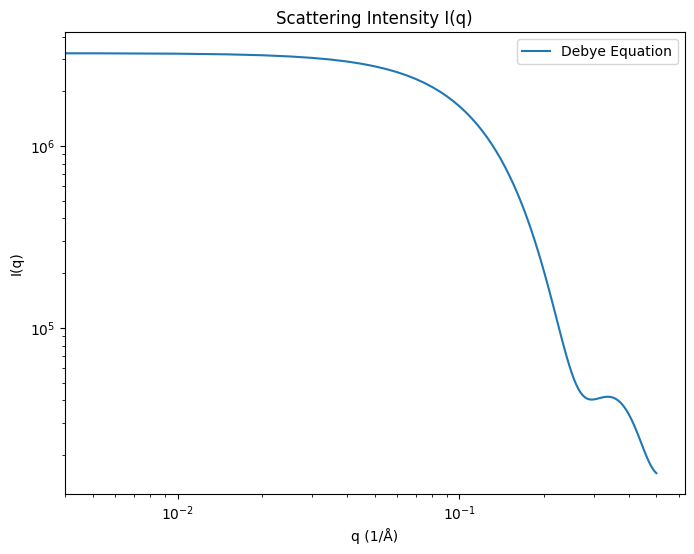

In [ ]:
debye.plot_Iq(qvals, Iqvals)
